# PPO, R-PPO and VAE comparison

In [ ]:
from runner import run
from parameters import Parameters, VAEParameters, PPOParameters, RPPOParameters

params = Parameters(agent=PPOParameters(entropy_c2=0.025), n_episodes=4000)
for p in params.repeat(10):
    run(p)

params = Parameters(agent=RPPOParameters(entropy_c2=0.025), n_episodes=4000)
for p in params.repeat(10):
    run(p)

params = Parameters(agent=VAEParameters(), n_episodes=4000)
for p in params.repeat(10):
    run(p)

## Score over training time

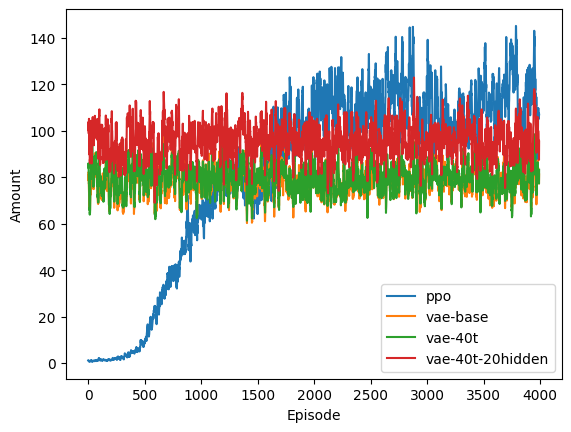

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Experiment

logdirs = {
    "ppo": "logs/ppo/2025-05-21T11-03-57.868549/",
    "vae-base": "logs/vae/2025-05-21T17-58-17.921210/",
    "vae-40t": "logs/vae/2025-05-21T20-22-56.256023/",
    "vae-40t-20hidden": "logs/vae/2025-05-21T20-28-41.368225/"
}

def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), 'valid') / w

for label, logdir in logdirs.items():
    logs = Experiment.from_directory(logdir)

    mean = np.mean(logs.amounts_over_time, axis=0)
    mean = moving_average(mean, 10)
    ci95 = 1.96 * np.std(logs.amounts_over_time, axis=0) / np.sqrt(len(logs.amounts_over_time))
    ci95 = moving_average(ci95, 10)
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Amount")
plt.legend()



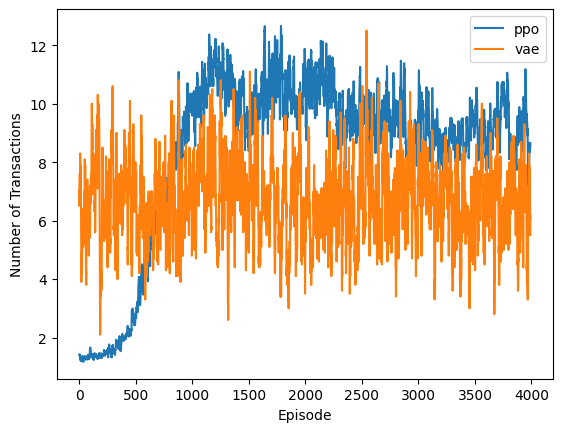

In [2]:
for label, logdir in logdirs.items():
    logs = Experiment.from_directory(logdir)

    mean = np.mean(logs.n_transactions_over_time, axis=0)
    mean = moving_average(mean, 10)
    plt.plot(mean, label=label)
    # plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Number of Transactions")
plt.legend()
